# Taux d'occupation des salles, campus Lombarderie FST

## Définitions

In [1]:
# Bibliothèques
import ics
import math
from datetime import date
import datetime

from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
%matplotlib inline



# Configuration

annee = 2019

if annee == 2019:
    #2019
    reftimestamp = datetime.datetime(2019,8,26,0,0,0).timestamp() # = 26/8/2019 à 0h00m00
    passageheurehiverTS = datetime.datetime(2019,10,27,0,0,0).timestamp() # = 27/10/2019 à 0h00m00
    passageheureeteTS = datetime.datetime(2020,3,29,0,0,0).timestamp() 
else:
    #2018
    reftimestamp = datetime.datetime(2018,8,27,0,0,0).timestamp()
    passageheurehiverTS = datetime.datetime(2018,10,28,0,0,0).timestamp()
    passageheureeteTS = datetime.datetime(2019,31,29,0,0,0).timestamp() 

NbSemainesS1 = 13
NbSemainesS2 = 13
NbJoursparSemaine = 5
NbHeuresparJour = 8

    
# Quelques fonctions utiles

# Lecture d'un calendrier en mémoire
def readcal(filename):
    fd=open(filename,"r")
    content=""
    for l in fd:
        content=content+"\n"+l
    fd.close()
    cal=ics.Calendar(content)
    return cal

# récupération des fichiers sur CELCAT
def recuperationFichiers(annee):
    if annee == 2019:
        # Pour 2019 sur sciences-bis
        !curl https://edt.univ-nantes.fr/sciences/g355056.ics -o 2019_L1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355055.ics -o 2019_L2.ics
        !curl https://edt.univ-nantes.fr/sciences/g355687.ics -o 2019_L3.ics
        !curl https://edt.univ-nantes.fr/sciences/g355732.ics -o 2019_M1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355740.ics -o 2019_M2.ics
        !curl https://edt.univ-nantes.fr/sciences/g351309.ics -o 2019_TREMPLIN.ics
        !curl https://edt.univ-nantes.fr/sciences/g913556.ics -o 2019_ACCOMPLI.ics
        !curl https://edt.univ-nantes.fr/sciences/g918815.ics -o 2019_DUEIL.ics
        !curl https://edt.univ-nantes.fr/sciences/g351082.ics -o 2019_DUG.ics
        !curl https://edt.univ-nantes.fr/sciences/g351317.ics -o 2019_UED.ics
        !curl https://edt.univ-nantes.fr/sciences/g351316.ics -o 2019_TUTO.ics
        !curl https://edt.univ-nantes.fr/sciences/g355731.ics -o 2019_M1MEEF.ics
        !curl https://edt.univ-nantes.fr/sciences/g355738.ics -o 2019_M2MEEF.ics
    else:
        # Pour 2018 sur sciences (Plus d'acualité.... car 2019 est maintenant sur sciences)
        !curl https://edt.univ-nantes.fr/sciences/g355056.ics -o 2018_L1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355055.ics -o 2018_L2.ics
        !curl https://edt.univ-nantes.fr/sciences/g355687.ics -o 2018_L3.ics
        !curl https://edt.univ-nantes.fr/sciences/g355732.ics -o 2018_M1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355740.ics -o 2018_M2.ics
        !curl https://edt.univ-nantes.fr/sciences/g351309.ics -o 2018_TREMPLIN.ics
        !curl https://edt.univ-nantes.fr/sciences/g522202.ics -o 2018_ACCOMPLI.ics
        !curl https://edt.univ-nantes.fr/sciences/g918815.ics -o 2018_DUEIL.ics
        !curl https://edt.univ-nantes.fr/sciences/g351082.ics -o 2018_DUG.ics
        !curl https://edt.univ-nantes.fr/sciences/g351317.ics -o 2018_UED.ics
        !curl https://edt.univ-nantes.fr/sciences/g351316.ics -o 2018_TUTO.ics
        !curl https://edt.univ-nantes.fr/sciences/g355731.ics -o 2018_M1MEEF.ics
        !curl https://edt.univ-nantes.fr/sciences/g355738.ics -o 2018_M2MEEF.ics

# Récupération des infos stockées dans la description de l'évènement CELCAT
def getInfo(e):
    T_info=dict()
    for x in e.description.split("\n"):
        if len(x)>0:
            a=x[0:x.find(" : ")]
            b=x[x.find(" : ")+3:]
            T_info[a]=b
    if T_info.get("Groupe"):
        T_info["Groupe"]=T_info.get("Groupe").split(", ")
    if T_info.get("Salle"):
        T_info["Salle"]=T_info.get("Salle").split(", ")
    return T_info
                        
# Etant donné 
# 1) le type de salle entre (Amphi, TD, TP, salle info)
# 2) le tableau T qui stocke, minute par minute sur tout une année, pour toutes les salles, le nombre de créneaux trouvés dans les différents calendriers
# calcule la somme, semestre par semestre d'heures d'occupation des salles
def NbHeuresParSemestre(typesalle,T):
    NbHeuresS1 = dict()
    NbHeuresS2 = dict()
    #typesalle = "TD"

    for s in T:
        if ("Bât" in s and "Bât A" not in s):
            if (typesalle in s):
                NbHeuresS1[s]=100*sum([1 for x in T.get(s)[0:18*7*24*60] if x>0])/60/(NbSemainesS1*NbJoursparSemaine*NbHeuresparJour)        
    for s in T:
        if ("Bât" in s and "Bât A" not in s):
            if (typesalle in s):
                NbHeuresS2[s]=100*sum([1 for x in T.get(s)[18*7*24*60+1:] if x>0])/60/(NbSemainesS2*NbJoursparSemaine*NbHeuresparJour)
    return [NbHeuresS1,NbHeuresS2]

# Renvoie les salles dont les exploitations sont comprises entre deux bornes (soit au S1, soit au S1 soit sur les deux semestres), pour un type de salle donné et connaissant NbHeuresS1 et NbHeuresS1
# Exemple 1 : Salles de TP sous exploitées sur l'année
# Exploitation('TP',ub=10,sem="all")
# Exemple 2 : Salles de TD sur-exploitées au S2
# Exploitation('TP',lb=70,sem="S2")

def Exploitation(typesalle,lb=0,ub=200,sem="all"):
    for s in NbHeuresS2[typesalle]:
        if sem == "all":
            test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub and NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub )
        else:
            if sem == "S1":
                test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub)
            else:
                test = (NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub)                
        if test:
            print(s,"\tOccupation S1 =",NbHeuresS1[typesalle].get(s),"\tOccupation S2 =",NbHeuresS2[typesalle].get(s))


def CourbeJourneeMoy(salle,debut=0,fin=24):
    NormalisationS1 = 100/(NbSemainesS1*NbJoursparSemaine)
    NormalisationS2 = 100/(NbSemainesS2*NbJoursparSemaine)
    
    scale=[debut + i/60 for i in range(60*(fin-debut))]

    TDraw=[0 for i in range(24*60)]
    for i in range(0,18*7*24*60):
        if T.get(salle)[i]>0:
            TDraw[i % (24*60)] += NormalisationS1
    TDrawS = gaussian_filter1d(TDraw, sigma=2)
    plt.plot(scale,TDrawS[(debut+1)*60:(fin+1)*60])
    TDraw=[0 for i in range(24*60)]
    for i in range(18*7*24*60,len(T.get(salle))):
        if T.get(salle)[i]>0:
            TDraw[i % (24*60)] += NormalisationS2
    TDrawS = gaussian_filter1d(TDraw, sigma=2)
    plt.plot(scale,TDrawS[(debut+1)*60:(fin+1)*60])
    plt.show()
    
    
    
    
def CourbeResume(typesalle):
    plt.title(typesalle)
    plt.bar(range(len(NbHeuresS1[typesalle])), list(NbHeuresS1[typesalle].values()), align='center')
    plt.bar(range(len(NbHeuresS2[typesalle])), list(NbHeuresS2[typesalle].values()), align='center')
    plt.legend(["S1","S2"])
    plt.show()
    
    
def CourbeJournee(typesalle):
    for s in NbHeuresS2[typesalle]:
        plt.title(s)
        CourbeJourneeMoy(s,7,20)

## Lecture des fichiers sur Celcat

In [2]:
# récupérations des fichiers sur le serveur CELCAT

recuperationFichiers(annee)

# Pour des raisons d'efficacité et parce que readcal prend du temps, on stocke les calendriers lus en mémoires
# reset du dictionnaire qui stocke les calendriers (à chaque fois qu'on récurère les fichiers sur Celcat)
MemoryCal=dict()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5297k  100 5297k    0     0  13.4M      0 --:--:-- --:--:-- --:--:-- 13.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4458k  100 4458k    0     0  12.5M      0 --:--:-- --:--:-- --:--:-- 12.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3836k  100 3836k    0     0  12.2M      0 --:--:-- --:--:-- --:--:-- 12.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3295k  100 3295k    0     0  12.0M      0 --:--:-- --:--:-- --:--:-- 12.0M
  % Total    % Received % Xferd  Average Speed   Tim

## Chargement en mémoire et interprétation des calendriers

In [3]:
# Lecture des calendriers.
# en sortie, on obtient les listes suivantes :
#     T qui stocke, pour chaque salle et minute par minute le nombre d'évènements qui ont lieu dans cette salle (Rq: si ce nombre est >0, alors la salle est occupée)
#     Matieres qui stocke, pour chaque salle, les modules qui ont au moins un créneau dans la salle
#     Groupes qui stocke, pour chaque salle, les groupes qui ont au moins un créneau dans la salle
#     SubCal, non utilisé actuellement, mais qui permet de reconstruire, au format ICS un calendrier spécifique pour chaque salle

T=dict()
Matieres=dict()
Groupes=dict()
SubCal=dict()

listeavecCMamphi = ["L1.ics","L2.ics"]
listeavecCMsallesTD = ["L3.ics","M1.ics","M2.ics","ACCOMPLI.ics","TREMPLIN.ics","DUEIL.ics","DUG.ics","TUTO.ics","M1MEEF.ics","M2MEEF.ics"]


for c in listeavecCMamphi+listeavecCMsallesTD:
    print("Traitement de ",c)
    if not MemoryCal.get(c):
        MemoryCal[c] = readcal(str(annee)+"_"+c)
    cal = MemoryCal.get(c)
    for e in cal.events:
        typecreneau = e.name.split(" ")[0]
        if typecreneau == "TD" or typecreneau == "CTDI":
            typecreneau = "TD/CTDI"
        if True: #(typecreneau == "TD/CTDI" or typecreneau == "CM" or typecreneau == "TP" or typecreneau == "CC"):
            if e.begin.timestamp<passageheurehiverTS or e.begin.timestamp>passageheureeteTS:
                decalageheurehiver = 60
            else:
                decalageheurehiver = 0
            deb=math.ceil((e.begin.timestamp-reftimestamp )/60+decalageheurehiver)
            fin=math.ceil((e.end.timestamp-reftimestamp )/60+decalageheurehiver)
            t=deb
            Infos=getInfo(e)
            if Infos.get("Salle"):
                for s in Infos.get("Salle"):
                    if not T.get(s):
                        T[s]=[0 for i in range(365*24*60)]
            
                while(t < fin):
                    i=int(t)
                    for s in Infos.get("Salle"):
                        T[s][i]=T[s][i]+1
                    t=t+1
                if not Matieres.get(s):
                    Matieres[s]=list()
                
                if Infos.get("Matière") and Infos.get("Matière") not in Matieres.get(s):
                    Matieres[s].append(Infos.get("Matière"))

                if not Groupes.get(s):
                    Groupes[s]=list()
                
                if Infos.get("Groupe"):
                    Groupes[s]=list(set(Groupes[s]+Infos.get("Groupe")))
                    
                if not SubCal.get(s):
                    SubCal[s]=list()
                
                SubCal[s].append(e)

Traitement de  L1.ics
Traitement de  L2.ics
Traitement de  L3.ics
Traitement de  M1.ics
Traitement de  M2.ics
Traitement de  ACCOMPLI.ics
Traitement de  TREMPLIN.ics
Traitement de  DUEIL.ics
Traitement de  DUG.ics
Traitement de  TUTO.ics
Traitement de  M1MEEF.ics
Traitement de  M2MEEF.ics


## Vision globale par semestre de l'occupation des salles (par type)

In [4]:
# premier affichage : vision globale par semestre de l'occupation des salles

NbHeuresS1=dict()
NbHeuresS2=dict()

for typesalle in ['Amphi','TD','TP','salle info']:
    [NbHeuresS1[typesalle],NbHeuresS2[typesalle]]=NbHeuresParSemestre(typesalle,T)



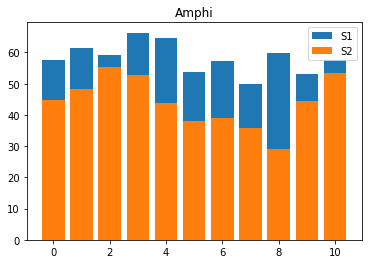

In [5]:
CourbeResume('Amphi')

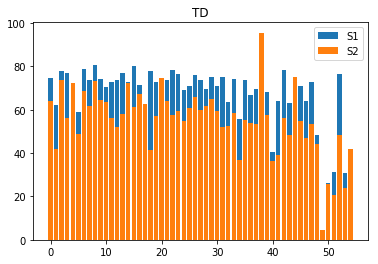

In [6]:
CourbeResume('TD')

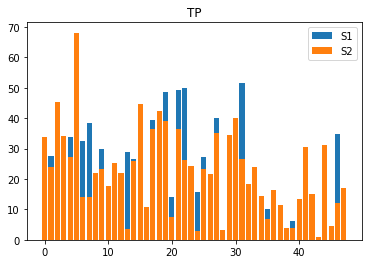

In [7]:
CourbeResume('TP')

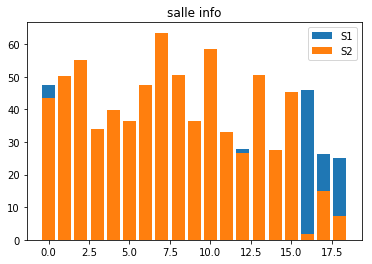

In [8]:
CourbeResume('salle info')

## Vision précise par salle et par créneau de la journée

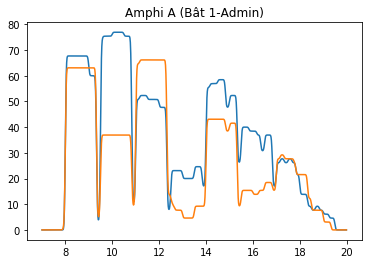

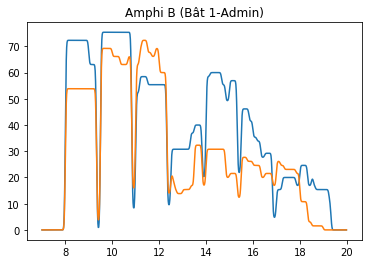

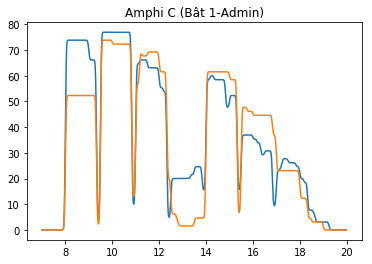

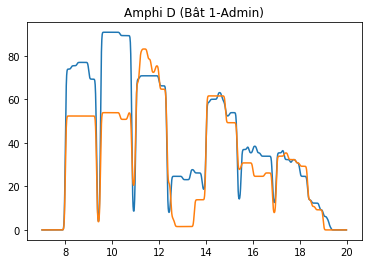

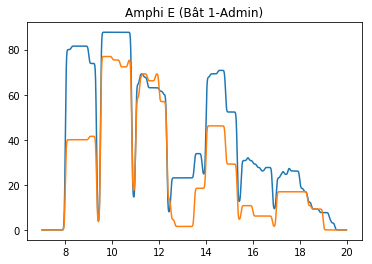

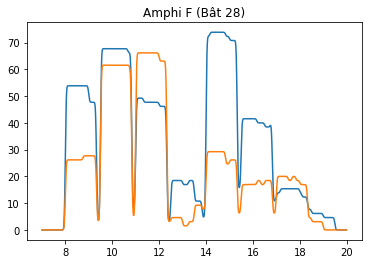

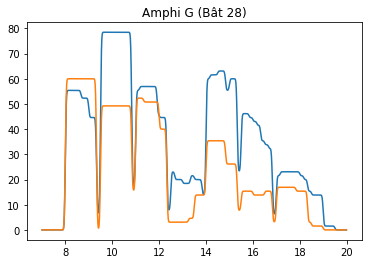

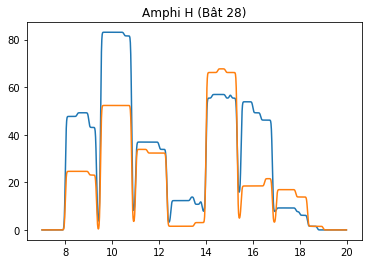

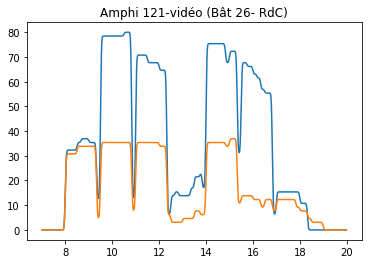

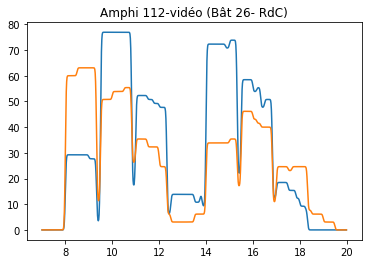

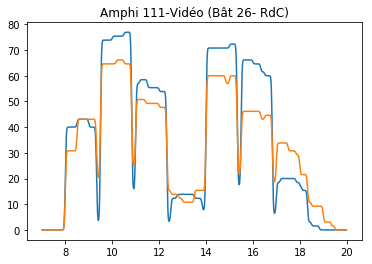

In [9]:
CourbeJournee('Amphi')

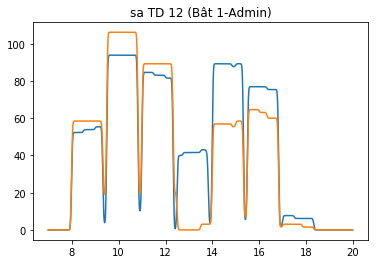

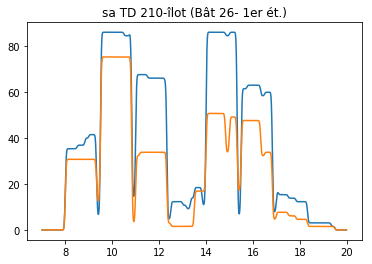

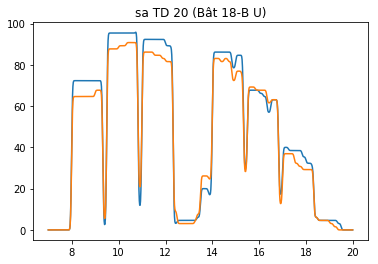

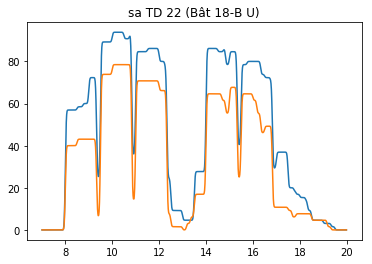

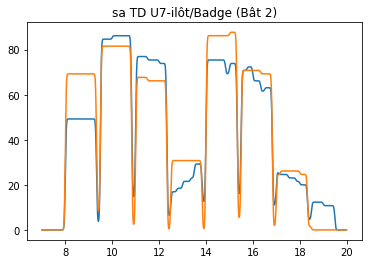

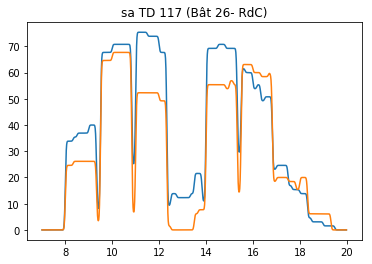

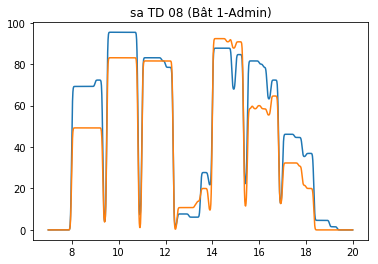

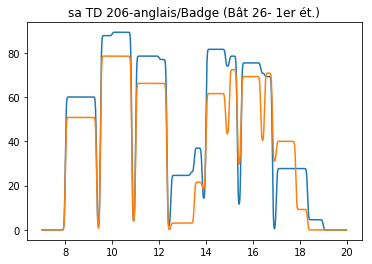

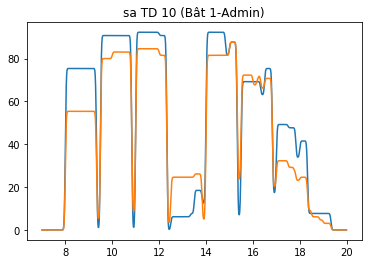

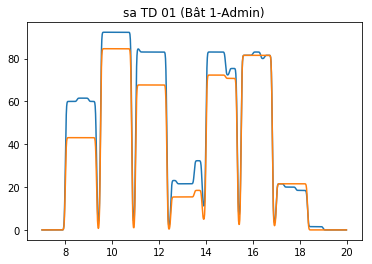

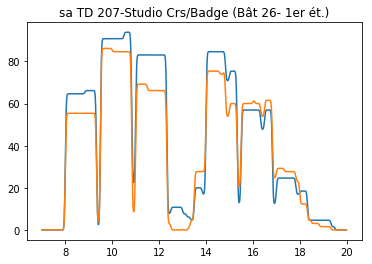

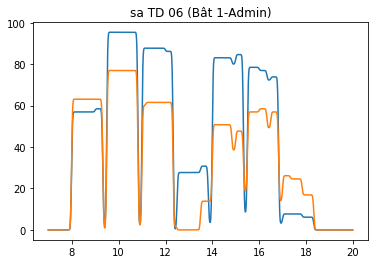

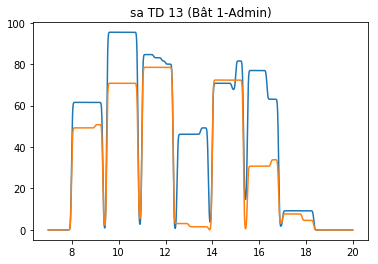

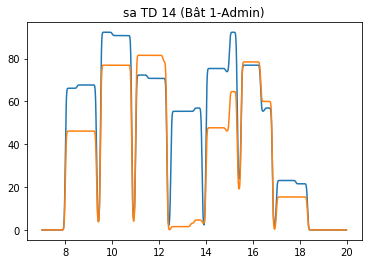

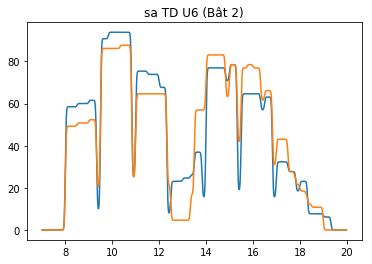

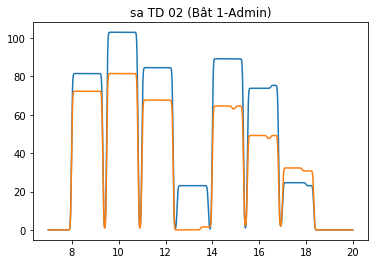

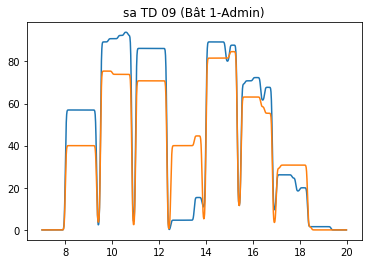

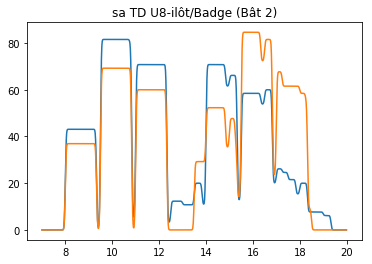

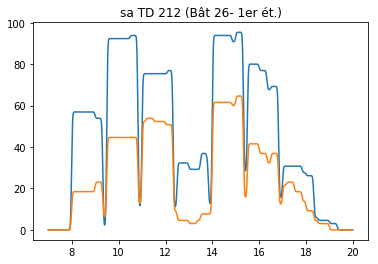

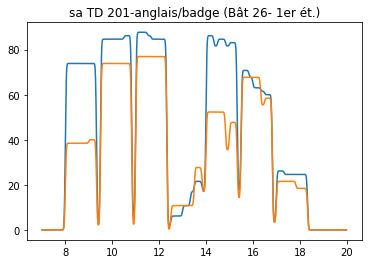

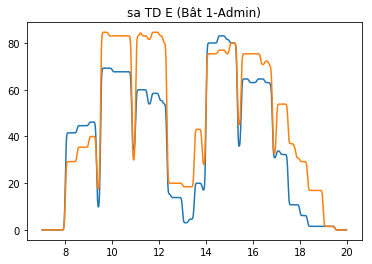

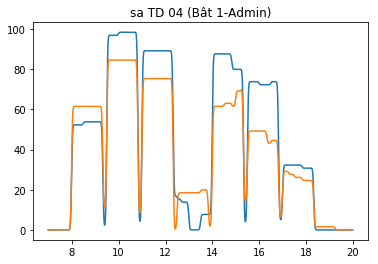

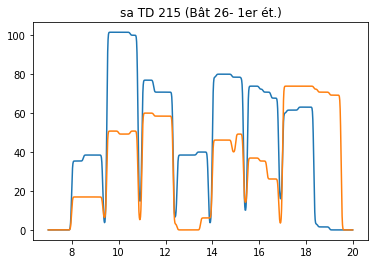

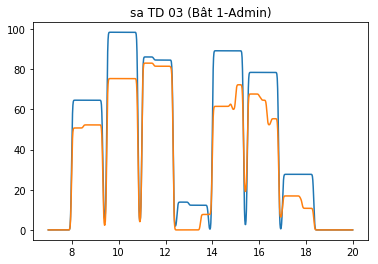

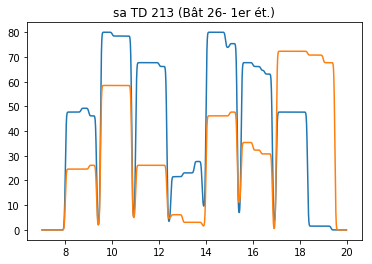

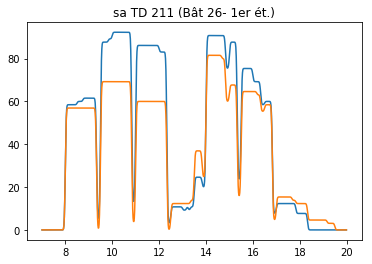

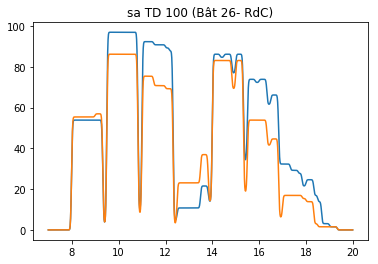

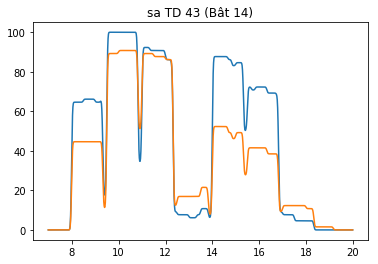

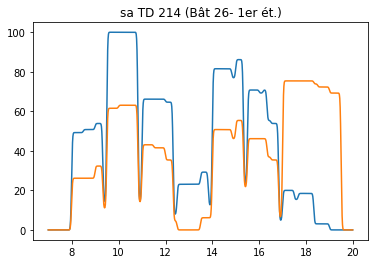

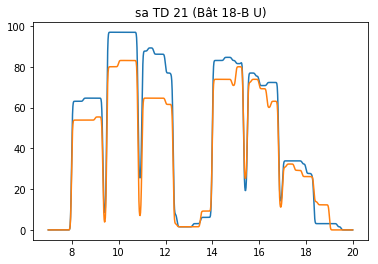

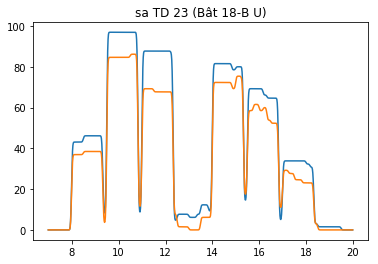

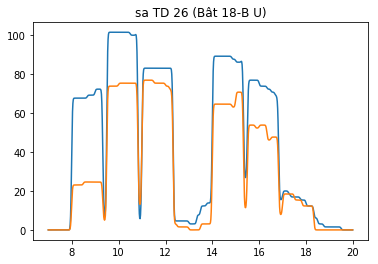

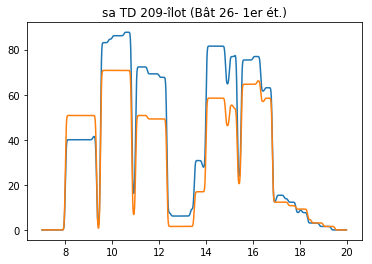

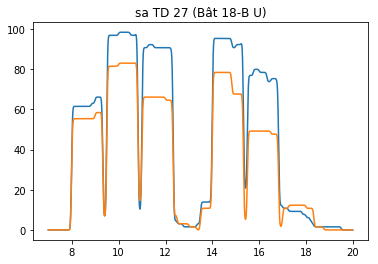

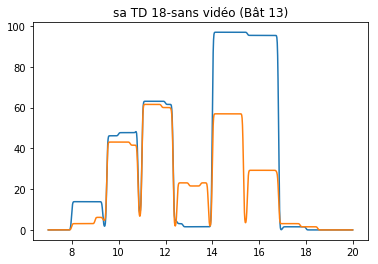

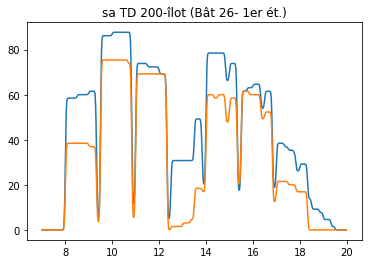

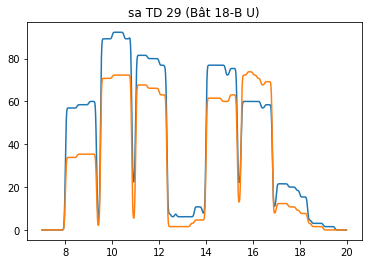

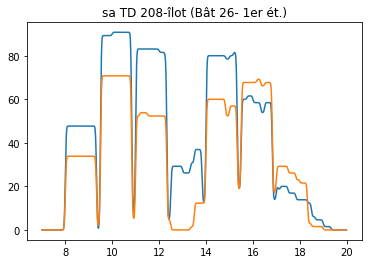

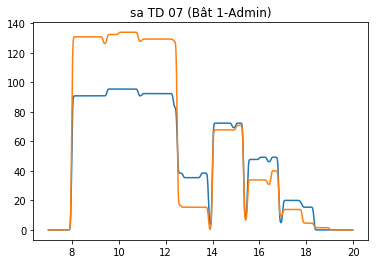

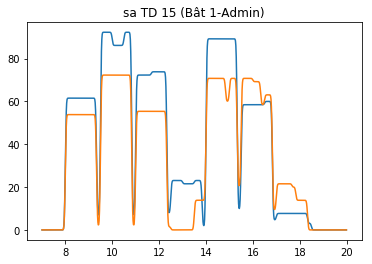

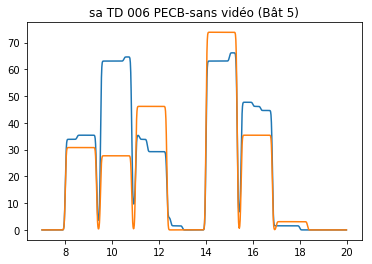

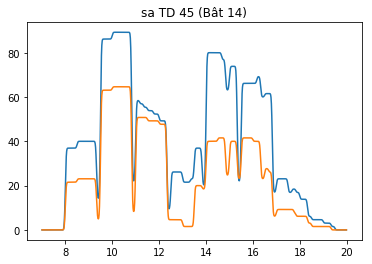

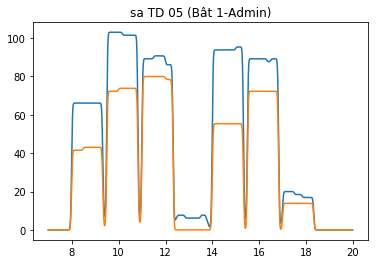

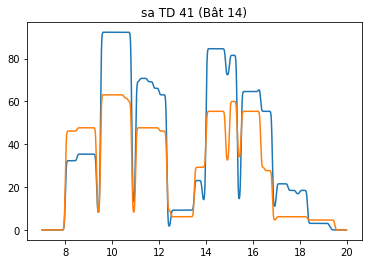

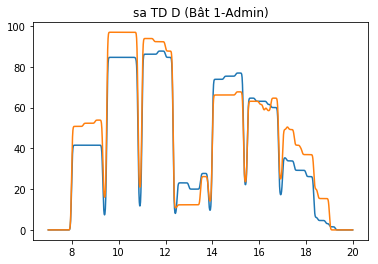

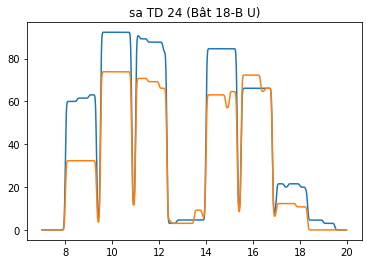

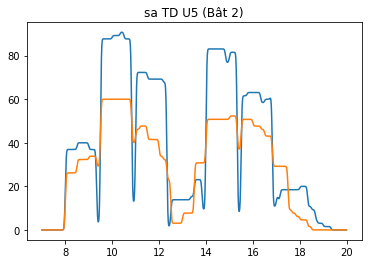

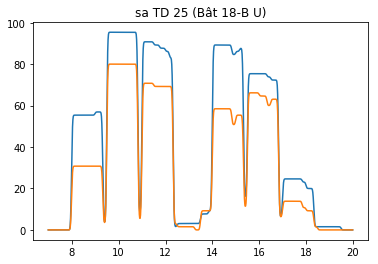

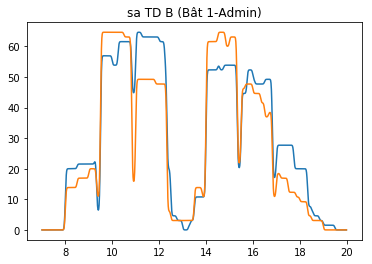

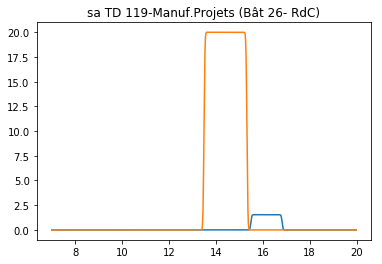

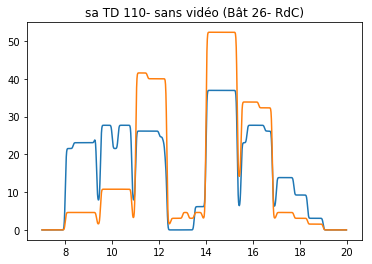

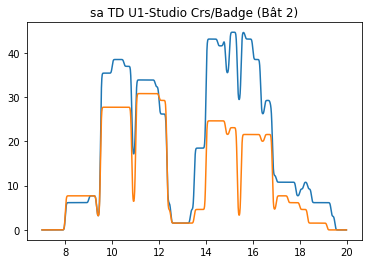

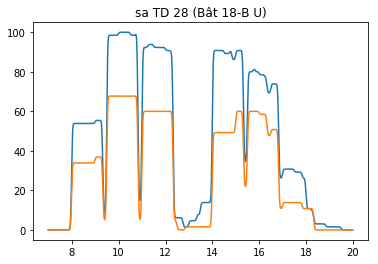

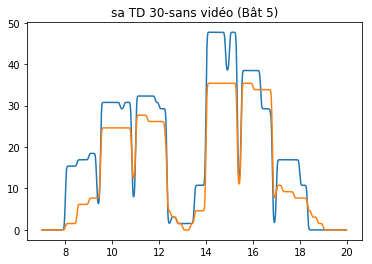

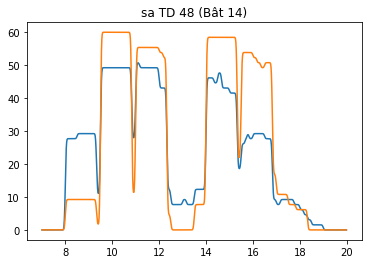

In [10]:
CourbeJournee('TD')  

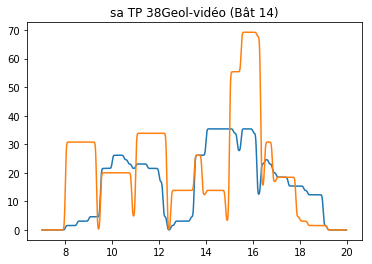

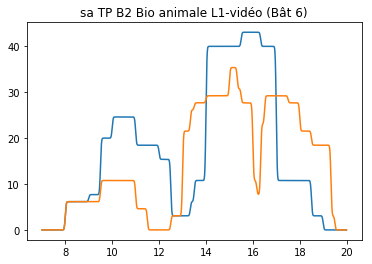

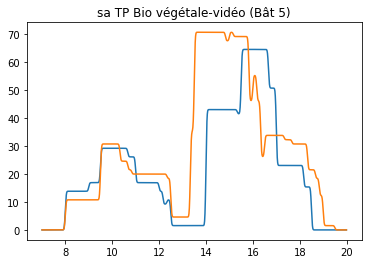

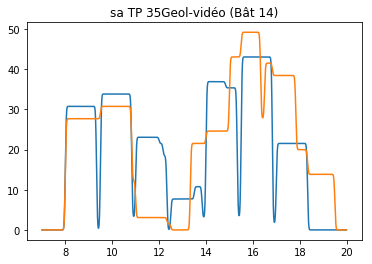

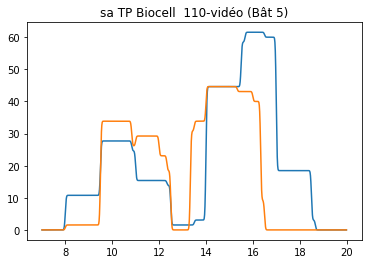

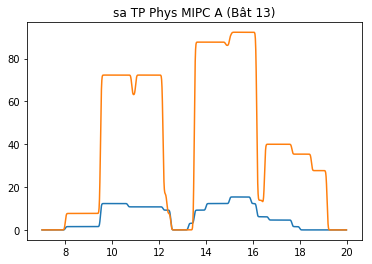

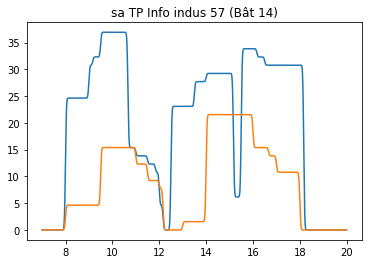

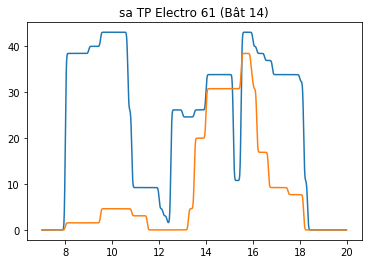

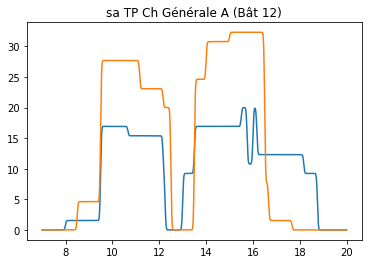

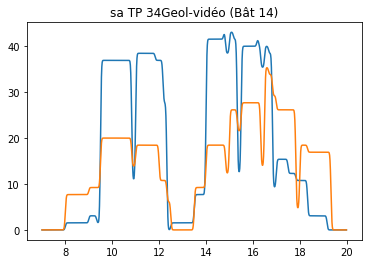

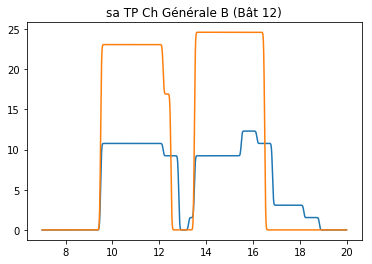

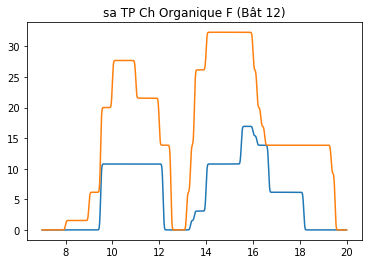

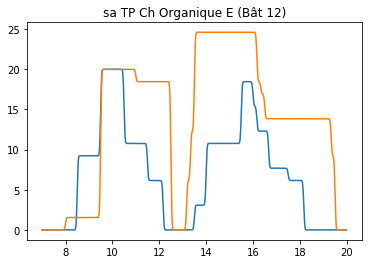

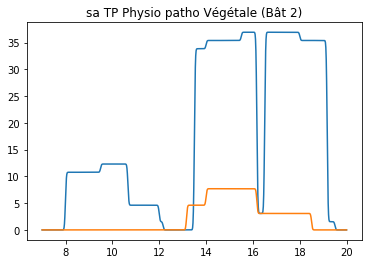

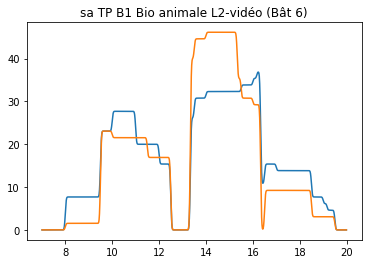

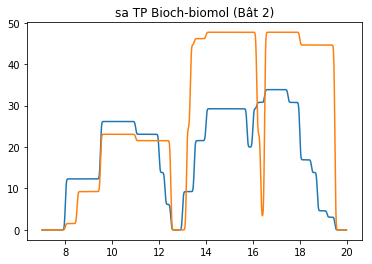

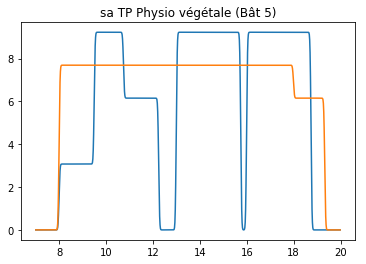

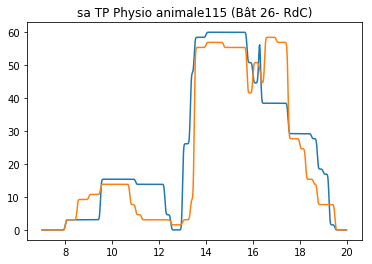

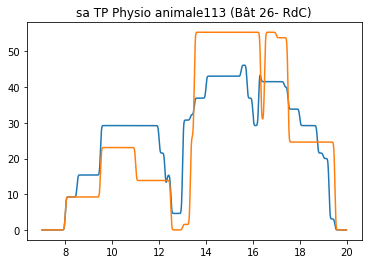

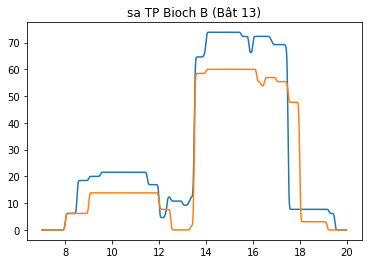

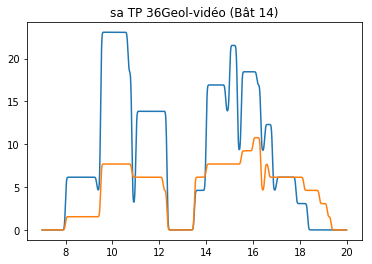

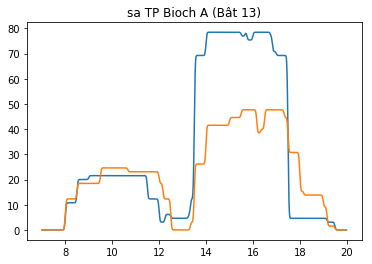

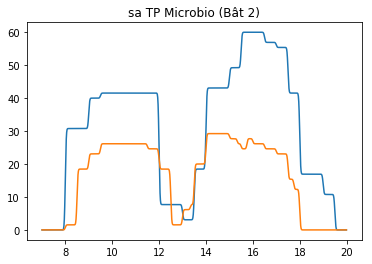

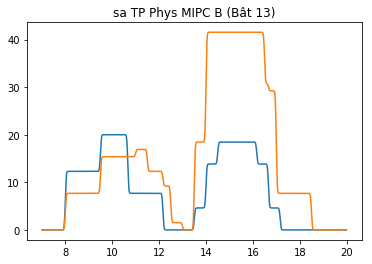

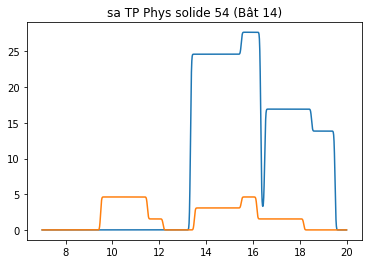

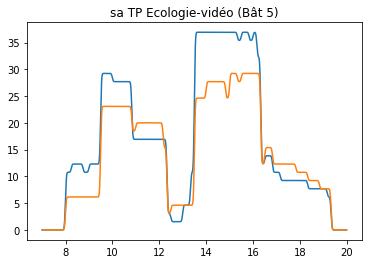

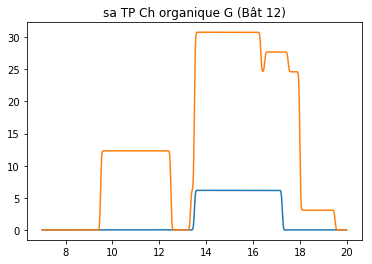

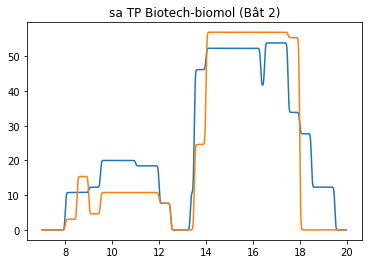

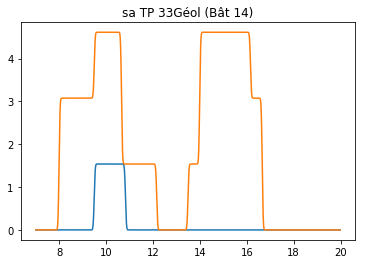

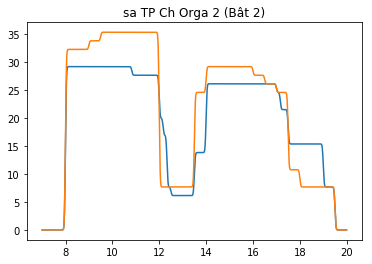

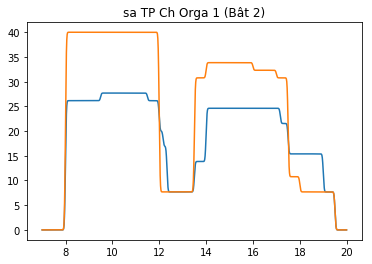

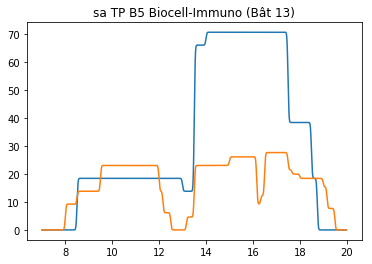

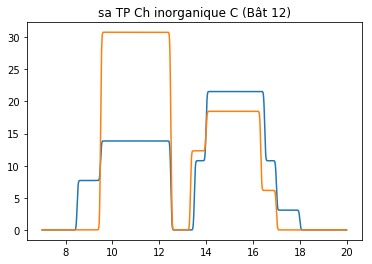

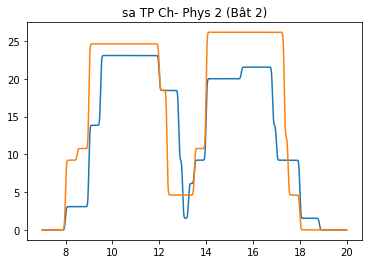

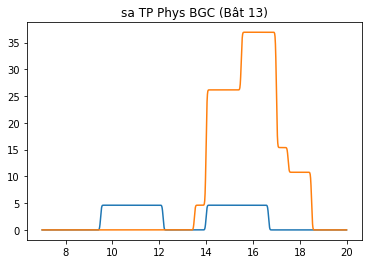

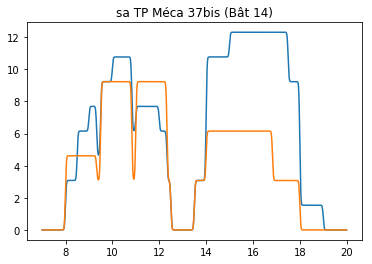

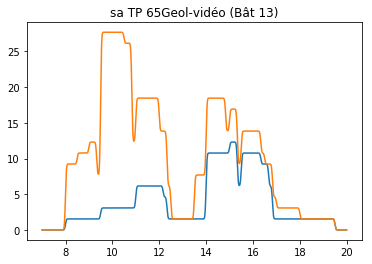

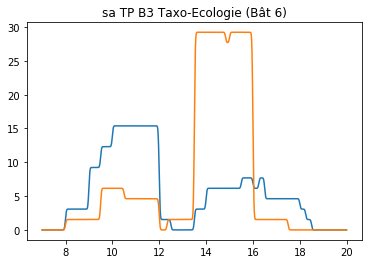

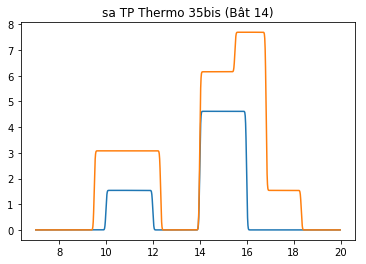

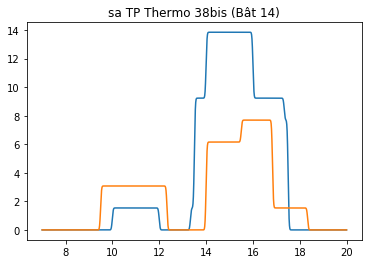

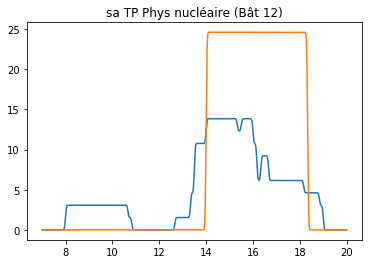

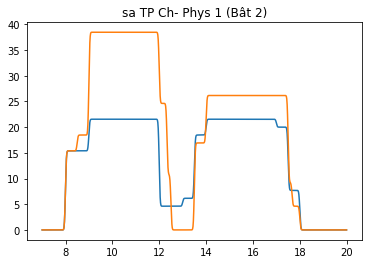

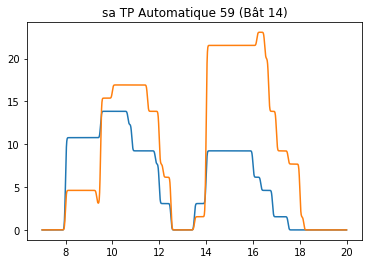

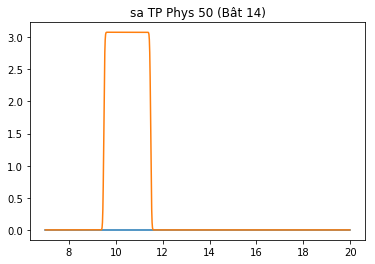

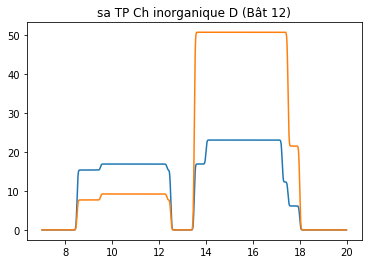

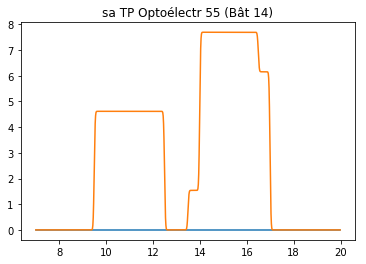

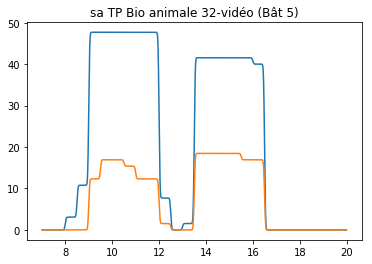

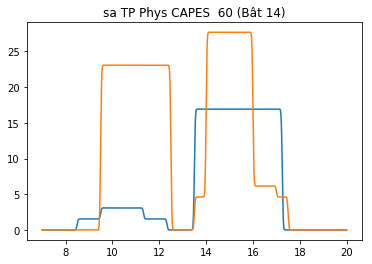

In [11]:
CourbeJournee('TP')  

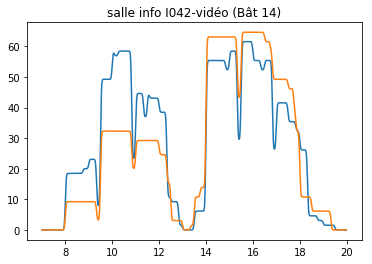

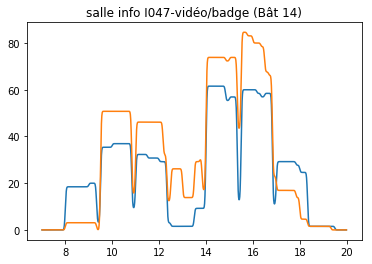

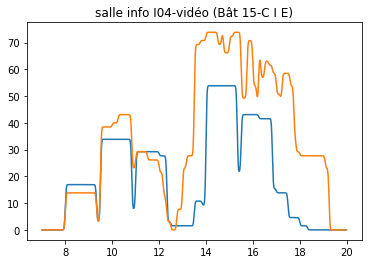

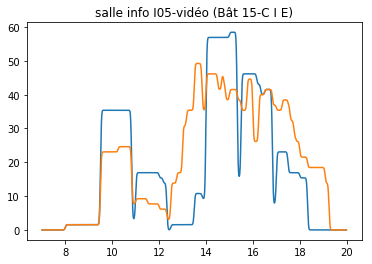

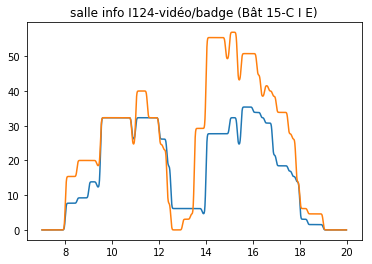

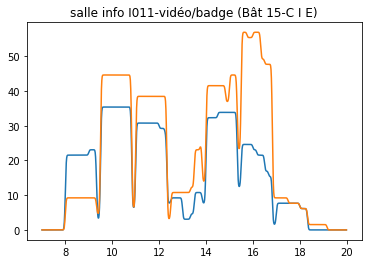

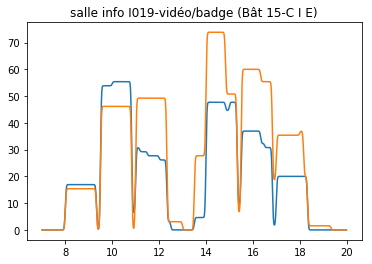

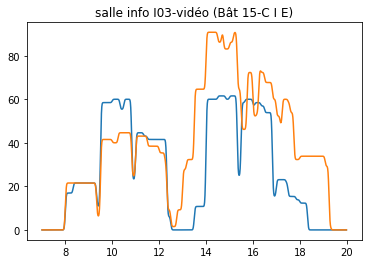

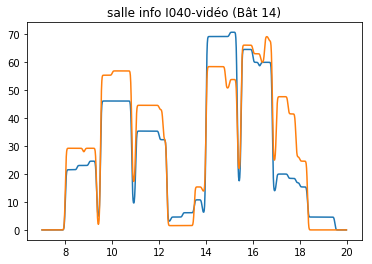

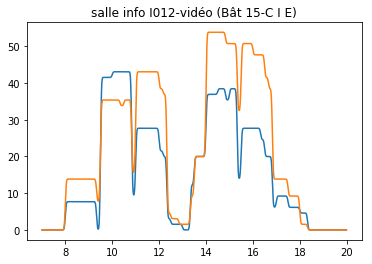

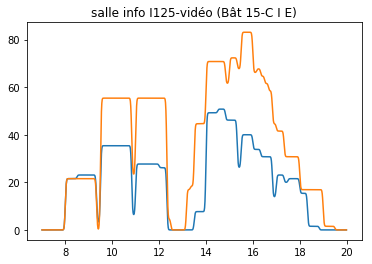

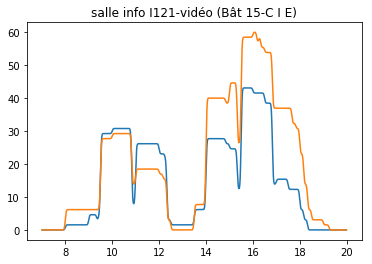

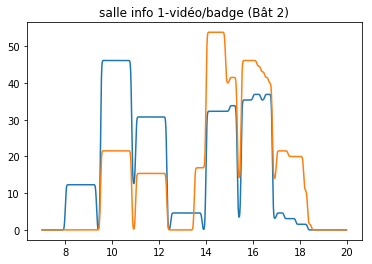

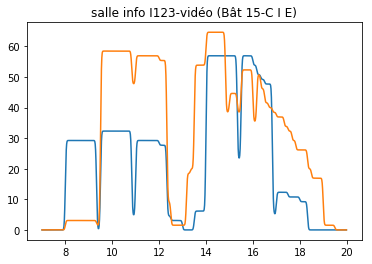

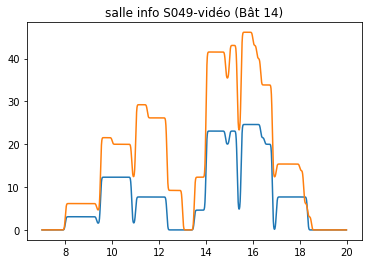

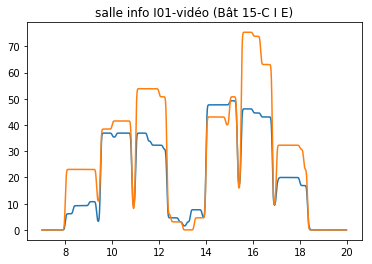

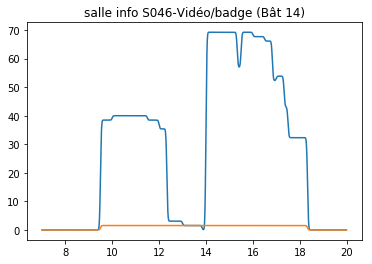

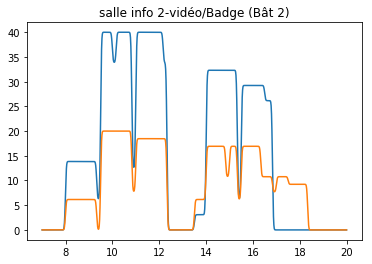

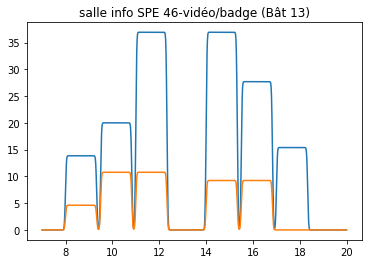

In [12]:
CourbeJournee('salle info')

In [13]:
# Un affichage textuel des matières et des groupes qui utilisent les salles de TP (non exploité et non exécuté)

for s in NbHeuresS2['TP']:
    print(s)
    print("----- Matières ------")
    print(Matieres.get(s))
    print("----- Groupes  ------")
    print(Groupes.get(s))
    print("---------------------")

sa TP 38Geol-vidéo (Bât 14)
----- Matières ------
['Roches et Minéraux (X12G050)', 'Minéralogie et pétrologie endogène (X21G010)', 'Pétrologie magmatique et métamorphique 1 (X22G052)', 'Synthèse géologique régionale (X32G051)', 'Tectonique globale et géologie de la France (X31G030)', 'Géomorphologie - CM et TP (X1TU052)', 'Expé et analyses en labo et sur terrain (X3TU030)', 'Sciences de la Vie et de la Terre (XTRG010)']
----- Groupes  ------
['M1STU', '222E', 'TR-3E', '222F', '224J', '335E', '235E', '235F', 'M1BGE', '223G', '220B', '321C', '236G', '224I', '221D', '223H', '321D', '322E', 'TR-3F', '635F', '220A', 'TR-1A', '320A', '535E', 'TR-1B', '221C', '435F', 'M2TP', '320B', 'PALP-STU']
---------------------
sa TP B2 Bio animale L1-vidéo (Bât 6)
----- Matières ------
['Biologie des organismes - Biologie Animale 2 (X12B032)', 'Biologie des organismes - Biologie animale 1 (X11B021)', 'Systématique animale (X22B192)', "Diversité biologique animale à travers l'évolution (X21B150)", 'Shell

## Informations complémentaires

### En complément, les salles de TD et TP sous exploitées

In [14]:
Exploitation('TD',sem="all",ub=50)

sa TD 006 PECB-sans vidéo (Bât 5) 	Occupation S1 = 40.705128205128204 	Occupation S2 = 36.15384615384615
sa TD B (Bât 1-Admin) 	Occupation S1 = 48.381410256410255 	Occupation S2 = 44.26282051282052
sa TD 119-Manuf.Projets (Bât 26- RdC) 	Occupation S1 = 0.25641025641025644 	Occupation S2 = 4.583333333333334
sa TD 110- sans vidéo (Bât 26- RdC) 	Occupation S1 = 26.169871794871796 	Occupation S2 = 25.528846153846153
sa TD U1-Studio Crs/Badge (Bât 2) 	Occupation S1 = 31.057692307692307 	Occupation S2 = 20.641025641025642
sa TD 30-sans vidéo (Bât 5) 	Occupation S1 = 30.76923076923077 	Occupation S2 = 24.022435897435898
sa TD 48 (Bât 14) 	Occupation S1 = 37.88461538461539 	Occupation S2 = 42.08333333333333


In [15]:
Exploitation('TP',sem="all",ub=10)

sa TP 33Géol (Bât 14) 	Occupation S1 = 0.25641025641025644 	Occupation S2 = 3.076923076923077
sa TP Thermo 35bis (Bât 14) 	Occupation S1 = 1.5384615384615385 	Occupation S2 = 3.814102564102564
sa TP Thermo 38bis (Bât 14) 	Occupation S1 = 6.153846153846154 	Occupation S2 = 3.814102564102564
sa TP Phys 50 (Bât 14) 	Occupation S1 = 0.0 	Occupation S2 = 0.7692307692307693
sa TP Optoélectr 55 (Bât 14) 	Occupation S1 = 0.0 	Occupation S2 = 4.615384615384615
